# Práctica 1: Sensado y análisis de audio

**Clase:**
CDSI 2026
**Profesor:** Irvin Hussein Lopez Nava    
**Alumno:** Javier R



---



El objetivo de esta práctica es diseñar y evaluar un sistema de **clasificación de actividades domésticas a partir de señales de audio**

La recolección de datos se realizó de forma colaborativa, donde cada estudiante grabó audios en entornos domésticos, utilizando dispositivos de uso cotidiano.  

Las actividades consideradas en el estudio son las siguientes:

- **Baño:** bajarle al WC  
- **Cocina:** lavar platos  
- **Sala:** conversación  
- **Oficina:** música de fondo  
- **Múltiples lugares:** pasos al caminar  
- **Clase nula:** otros sonidos no asociados a las clases anteriores  

Cada estudiante grabó tres audios por clase.



## Librerías

In [3]:
# Sistema y archivos
import os
import re

# Audio
import librosa
import soundfile as sf
import numpy as np

# Datos y gráficas
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal

# Modelos de machine learning
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Obtención de los datos

Los archivos de audio utilizados en esta práctica se almacenan en Google Drive



Se definen las rutas de entrada y salida para el procesamiento de los audios.


In [4]:
input_path = "/content/drive/MyDrive/Audio"
path_1 = "/content/drive/MyDrive/P1"

os.makedirs(path_1, exist_ok=True)

# Procesamiento de los audios


In [5]:
def duracion_audio(path):
    # Obtiene la duración del audio en segundos
    # Se usa para filtrar o validar audios en el pipeline
    return librosa.get_duration(path=path)

In [6]:
CLASES_VALIDAS = ["bano", "cocina", "sala", "oficina", "pasos", "nula"]

Se define una expresión regular para validar el nombre de los archivos de audio.

El nombre debe tener tres partes separadas por guiones bajos.
La primera parte son letras mayúsculas que identifican al participante.
La segunda parte indica la clase del audio (bano, cocina, sala, oficina, pasos o nula).
La tercera parte es un número del 01 al 03 que distingue repeticiones.
El archivo debe terminar en extensión .wav.

Esto ayuda a mantener orden y consistencia en los datos del pipeline.


In [7]:
regex_nombre = re.compile(
    r"^([a-z]{2,5})_(bano|cocina|sala|oficina|pasos|nul[ao])_(0[1-3])\.wav$",
    re.IGNORECASE
)


Esta función sirve para corregir y validar el nombre de un audio.

- Pasa todo a minúsculas.
- Separa el nombre en partes.
- Revisa que la clase sea válida.
- Revisa que la muestra sea correcta.

Si cumple todo, devuelve el nombre con el formato correcto.
Si no, devuelve None.


In [8]:
def estandarizar_nombre(nombre):
    # Validar estructura completa con regex
    m = regex_nombre.match(nombre)
    if not m:
        return None

    ID_raw, clase_raw, muestra = m.groups()

    ID = ID_raw.upper()
    clase_raw = clase_raw.lower()

    # Normalizar nulo / nula
    if clase_raw.startswith("nul"):
        clase = "nula"
    else:
        clase = clase_raw

    # Validar clase final
    if clase not in CLASES_VALIDAS:
        return None

    return f"{ID}_{clase}_{muestra}.wav"


In [9]:
def reducir_ruido(audio, sr):
    return audio - np.mean(audio)

- Busca el valor máximo de la señal.

- Escala el audio para que quede entre -1 y 1.



In [10]:
def normalizar_audio(audio):
    max_val = np.max(np.abs(audio))
    if max_val > 0:
        audio = audio / max_val
    return audio


In [11]:
def recortar_a_10s(audio, sr, target_duration=10.0):
    max_samples = int(target_duration * sr)
    if len(audio) > max_samples:
        return audio[:max_samples], True
    return audio, False


Para cada audio `.wav`:
- Calcula su duración original.
- Revisa si el nombre cumple con el formato esperado.
- Marca si el audio necesita ser recortado o si el nombre es incorrecto.

Si el nombre es válido:
- Carga el audio.
- Lo recorta a 10 segundos si es necesario.
- Reduce ruido básico.
- Normaliza la amplitud.
- Guarda el audio procesado con el nombre estandarizado.


In [12]:
os.makedirs(path_1, exist_ok=True)

In [13]:
registros = []

for root, _, files in os.walk(input_path):
    for file in files:
        if not file.lower().endswith(".wav"):
            continue

        input_file = os.path.join(root, file)

        # ---- Duración original ----
        dur = duracion_audio(input_file)

        # ---- Nombre ----
        nuevo_nombre = estandarizar_nombre(file)
        nombre_ok = nuevo_nombre is not None

        estado = []

        if abs(dur - 10.0) > 0.05:
            estado.append("RECORTADO")

        if not nombre_ok:
            estado.append("NOMBRE")

        estado = "OK" if not estado else ",".join(estado)

        # ---- Procesamiento (solo si nombre válido) ----
        if nombre_ok:
            audio, sr = librosa.load(input_file, sr=None)

            # ---- Recorte ----
            audio, fue_recortado = recortar_a_10s(audio, sr)

            # ---- Ruido + Normalización ----
            audio = reducir_ruido(audio, sr)
            audio = normalizar_audio(audio)

            output_file = os.path.join(path_1, nuevo_nombre)
            sf.write(output_file, audio, sr)

        registros.append({
            "archivo_original": file,
            "archivo_final": nuevo_nombre,
            "duracion_original": round(dur, 3),
            "estado": estado
        })


In [14]:

# registros ya los llenaste en tu código anterior
df_registros = pd.DataFrame(registros)

# Guardar CSV
csv_path = os.path.join(path_1, "audios_registros.csv")
df_registros.to_csv(csv_path, index=False)
print(f"CSV guardado en: {csv_path}")


CSV guardado en: /content/drive/MyDrive/P1/audios_registros.csv


In [21]:
df = pd.DataFrame(registros)
df.head(5)

,archivo_original,archivo_final,duracion_original,estado
0,DISC_oficina_02.wav,DISC_oficina_02.wav,10.0,OK
1,DISC_sala_01.wav,DISC_sala_01.wav,10.0,OK
2,DISC_oficina_01.wav,DISC_oficina_01.wav,10.0,OK
3,DISC_pasos_02.wav,DISC_pasos_02.wav,10.0,OK
4,DISC_sala_03.wav,DISC_sala_03.wav,10.0,OK


In [ ]:
archivos = [
    f for f in os.listdir(path_1)
    if f.lower().endswith(".wav")
]

In [ ]:
registros = []

for f in archivos:
    nombre = f.replace(".wav", "")
    ID, clase, muestra = nombre.split("_")

    registros.append({
        "ID": ID,
        "clase": clase,
        "muestra": muestra,
        "archivo": f
    })

df = pd.DataFrame(registros)

In [ ]:
conteo_clase = df["clase"].value_counts().sort_index()
print(conteo_clase)

clase
bano       33
cocina     33
nula       33
oficina    33
pasos      33
sala       33
Name: count, dtype: int64


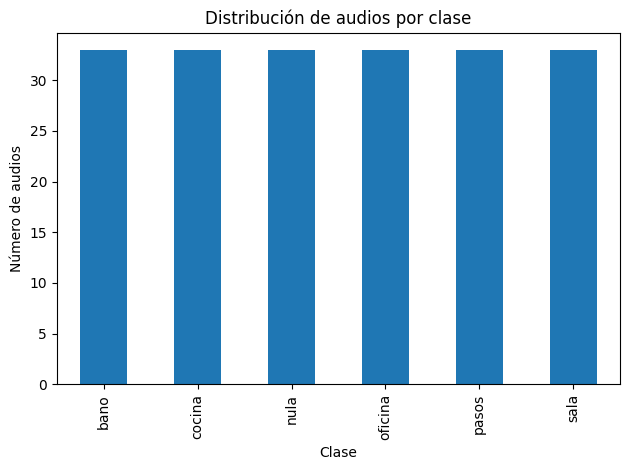

In [ ]:
plt.figure()
conteo_clase.plot(kind="bar")
plt.xlabel("Clase")
plt.ylabel("Número de audios")
plt.title("Distribución de audios por clase")
plt.tight_layout()
plt.show()


In [ ]:
# Conteo total de audios por ID
conteo_id = (
    df
    .groupby("ID")
    .size()
    .reset_index(name="n_audios")
)


# IDs que no tienen 18 audios
ids_incompletos = conteo_id[conteo_id["n_audios"] != 18]


print("IDs que NO tienen los 18 audios:")
if ids_incompletos.empty:
    print("Todos tienen 18")
else:
    print(ids_incompletos)


IDs que NO tienen los 18 audios:
Todos tienen 18


# Extracción y selección de características


- RMS: mide la energía promedio del audio.
- ZCR: indica cuántas veces la señal cruza por cero.

Se devuelve el promedio de cada descriptor para usarlo como características.


In [ ]:
def extraer_acustica_basica(audio, sr):
    rms = librosa.feature.rms(y=audio)[0]
    zcr = librosa.feature.zero_crossing_rate(audio)[0]

    return {
        "rms_mean": np.mean(rms),
        "zcr_mean": np.mean(zcr)
    }


In [ ]:
def duracion_efectiva(audio, sr):
    return len(audio) / sr

In [ ]:
registros_eda = []

for f in archivos:
    ruta = os.path.join(path_1, f)
    audio, sr = librosa.load(ruta, sr=None)

    ID, clase, _ = f.replace(".wav", "").split("_")

    feats = extraer_acustica_basica(audio, sr)

    registros_eda.append({
        "clase": clase,
        "rms": feats["rms_mean"],
        "zcr": feats["zcr_mean"],
        "duracion": duracion_efectiva(audio, sr)
    })

df_eda = pd.DataFrame(registros_eda)
df_eda.head(5)


,clase,rms,zcr,duracion
0,sala,0.014204,0.032024,10.0
1,nula,0.014293,0.021185,10.0
2,bano,0.072792,0.130667,10.0
3,sala,0.058841,0.064851,10.0
4,bano,0.047350,0.113444,10.0


<Figure size 640x480 with 0 Axes>

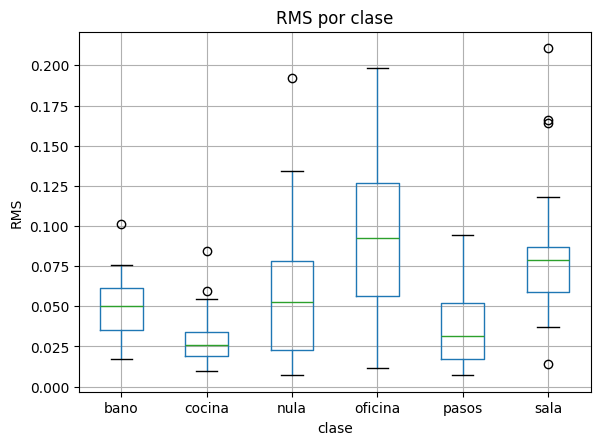

In [ ]:
plt.figure()
df_eda.boxplot(column="rms", by="clase")
plt.title("RMS por clase")
plt.suptitle("")
plt.ylabel("RMS")
plt.show()


<Figure size 640x480 with 0 Axes>

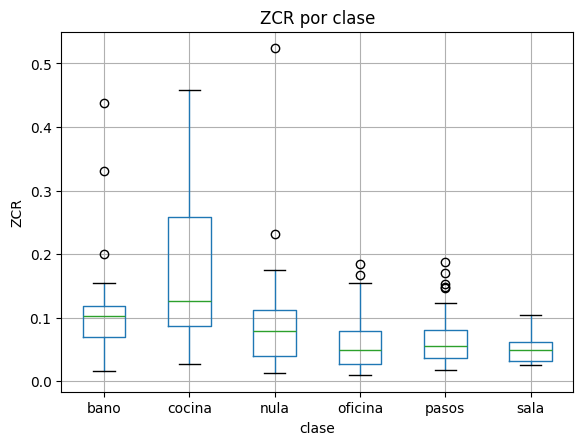

In [ ]:
plt.figure()
df_eda.boxplot(column="zcr", by="clase")
plt.title("ZCR por clase")
plt.suptitle("")
plt.ylabel("ZCR")
plt.show()


En esta parte se prepara el dataset final.

- De cada audio se obtienen:
  - MFCCs (13 coeficientes).
  - ZCR.
  - RMS.

- Cada audio queda asociado a su clase.

- Los datos se guardan en un DataFrame:
  - Filas: audios.
  - Columnas: características.

- Se divide el dataset en entrenamiento y prueba.


In [ ]:
def extraer_features(audio, sr, n_mfcc=13):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    zcr = librosa.feature.zero_crossing_rate(audio)
    rms = librosa.feature.rms(y=audio)

    features = {}

    for i in range(n_mfcc):
        features[f"mfcc_{i+1}"] = np.mean(mfcc[i])

    features["zcr"] = np.mean(zcr)
    features["rms"] = np.mean(rms)

    return features


In [ ]:
registros = []

for f in archivos:
    ruta = os.path.join(path_1, f)
    audio, sr = librosa.load(ruta, sr=None)

    ID, clase, _ = f.replace(".wav", "").split("_")

    feats = extraer_features(audio, sr)

    feats["clase"] = clase
    feats["ID"] = ID
    feats["archivo"] = f

    registros.append(feats)

df_features = pd.DataFrame(registros)
df_features.head(10)


,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,zcr,rms,clase,ID,archivo
0,-419.141815,124.466919,22.251299,-3.375592,7.366074,7.527985,2.311376,2.589935,-2.759017,-5.412106,0.490687,4.106471,2.776736,0.032024,0.014204,sala,DISC,DISC_sala_02.wav
1,-467.627106,125.502754,56.585472,19.702414,8.266678,1.264092,-6.163580,-4.014349,-0.617032,-1.260459,-0.235559,1.783186,3.404381,0.021185,0.014293,nula,DISC,DISC_nula_02.wav
2,-196.372070,73.966370,-10.591397,33.989197,0.070871,20.170256,-16.706692,10.517854,-15.212451,6.954167,-7.684958,4.088938,-3.819239,0.130667,0.072792,bano,DISC,DISC_bano_02.wav
3,-279.873627,134.423004,-18.865974,11.720263,1.184657,8.550214,-12.908230,1.768956,-7.583690,-3.779407,-1.249238,-0.226545,-3.930694,0.064851,0.058841,sala,DISC,DISC_sala_03.wav
4,-245.189316,91.214905,-3.711309,25.508844,-4.630531,16.045010,-20.462206,9.813781,-6.646360,7.869993,-6.087704,1.385116,-8.088947,0.113444,0.047350,bano,DISC,DISC_bano_03.wav
5,-380.898346,176.697128,21.366833,3.136870,17.845758,16.147646,-3.920152,-1.912823,-3.461331,-3.458277,-2.135466,1.382145,-0.747070,0.026792,0.018799,oficina,DISC,DISC_oficina_02.wav
6,-251.674637,122.676346,0.937010,20.452717,-0.928609,26.304438,-7.379632,16.392197,-7.274921,5.903677,-0.600234,6.315278,-3.064037,0.045475,0.049493,pasos,DISC,DISC_pasos_02.wav
7,-394.444305,186.198395,16.849220,15.129456,12.012649,15.106527,1.498603,3.507872,-3.081146,-1.880100,-5.129105,3.961530,-0.519265,0.028812,0.019379,oficina,DISC,DISC_oficina_01.wav
8,-373.375458,146.618240,26.305807,7.699545,17.958967,15.043187,7.075625,-2.442537,-8.683362,-7.249668,-3.584574,-1.761291,-1.134310,0.028792,0.052970,sala,DISC,DISC_sala_01.wav
9,-203.098114,117.575203,-41.271503,0.748642,-12.080083,28.196220,-7.879591,12.538599,6.629260,16.490845,-1.449996,4.191534,-5.963583,0.082526,0.063649,bano,DISC,DISC_bano_01.wav


In [ ]:
df_test = df_features[df_features["ID"] == "JMRR"]
df_train = df_features[df_features["ID"] != "JMRR"]


In [ ]:
df_test = (
    df_test
    .groupby("clase", group_keys=False)
    .head(3)
)


In [ ]:
X_train = df_train.drop(columns=["clase", "ID", "archivo"])
y_train = df_train["clase"]

X_test = df_test.drop(columns=["clase", "ID", "archivo"])
y_test = df_test["clase"]



In [ ]:
print("Train:")
print(df_train["clase"].value_counts())

print("\nTest:")
print(df_test["clase"].value_counts())


Train:
clase
sala       30
nula       30
bano       30
oficina    30
pasos      30
cocina     30
Name: count, dtype: int64

Test:
clase
bano       3
sala       3
oficina    3
pasos      3
nula       3
cocina     3
Name: count, dtype: int64


# Construcción y evaluación de modelos

Se entrena el modelo con los datos de entrenamiento.




In [ ]:
def evaluar_modelo(modelo, X_train, X_test, y_train, y_test, nombre):
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    f1 = f1_score(y_test, y_pred, average="macro")

    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=np.unique(y_test)
    )

    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Matriz de confusión – {nombre}")
    plt.show()

    print(f"{nombre} | F1-score macro: {f1:.4f}")

    return f1


In [ ]:
resultados = {}

## Random Forest

Se realizó una búsqueda de hiperparámetros para Random Forest utilizando GridSearchCV y F1-score macro como métrica.  
El objetivo fue reducir el sobreajuste controlando la profundidad de los árboles y el tamaño mínimo de los nodos.


In [ ]:
param_grid_rf = {
    "n_estimators": [100, 200, 300, 400],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}


In [ ]:
from sklearn.model_selection import GridSearchCV

rf_base = RandomForestClassifier(
    random_state=42,
    class_weight="balanced"
)

grid_rf = GridSearchCV(
    rf_base,
    param_grid_rf,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300, 400]},
             scoring='f1_macro')

In [ ]:
print("Mejores parámetros RF:")
print(grid_rf.best_params_)
print("Mejor F1 (CV):", grid_rf.best_score_)


Mejores parámetros RF:
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Mejor F1 (CV): 0.4491274629509924


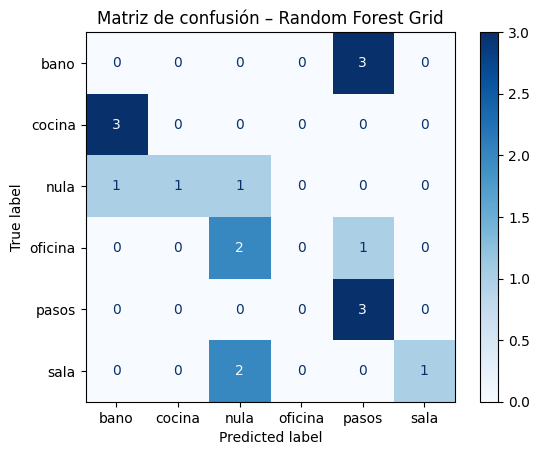

Random Forest Grid | F1-score macro: 0.2250


In [ ]:
rf_opt = grid_rf.best_estimator_

resultados["Random Forest (opt)"] = evaluar_modelo(
    rf_opt,
    X_train,
    X_test,
    y_train,
    y_test,
    "Random Forest Grid"
)


In [ ]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

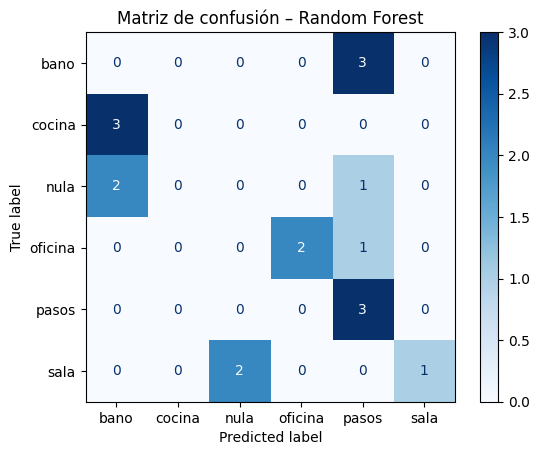

Random Forest | F1-score macro: 0.3076


In [ ]:
resultados["Random Forest"] = evaluar_modelo(
    rf, X_train, X_test, y_train, y_test, "Random Forest"
)

## SVM



In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [ ]:
pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(class_weight='balanced'))
])

In [ ]:
param_grid_svm = {
    'svm__kernel': ['rbf'],
    'svm__C': [1, 10, 100, 150, 200, 300],
    'svm__gamma': ['scale', 0.01]
}

In [ ]:
svm_grid = GridSearchCV(
    pipe_svm,
    param_grid_svm,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=1
)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


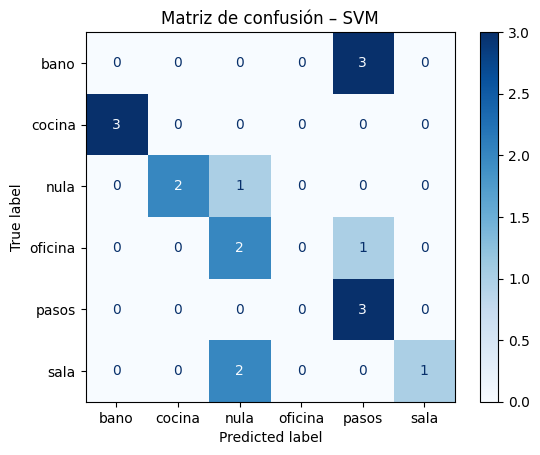

SVM | F1-score macro: 0.2250


In [ ]:
resultados["SVM0(opt)"] = evaluar_modelo(
    svm_grid, X_train, X_test, y_train, y_test, "SVM"
)

In [ ]:
print("Mejores parámetros SVM:")
print(svm_grid.best_params_)

Mejores parámetros SVM:
{'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}


In [ ]:
svm = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", C=10, gamma="scale"))
])


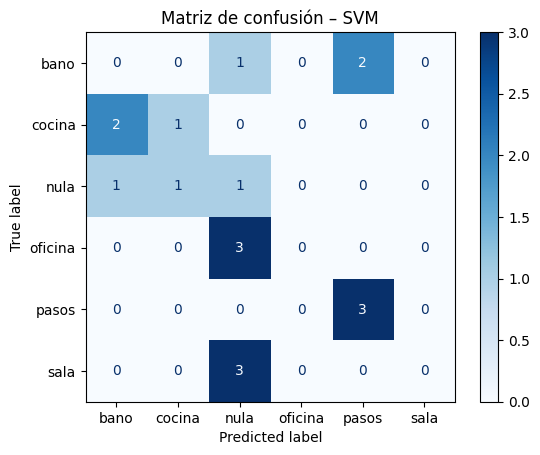

SVM | F1-score macro: 0.2220


In [ ]:
resultados["SVM"] = evaluar_modelo(
    svm, X_train, X_test, y_train, y_test, "SVM"
)

## KNN

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

knn_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier())
])


In [ ]:
param_grid_knn = {
    "clf__n_neighbors": list(range(1, 41)),

    "clf__weights": ["uniform", "distance"],

    "clf__metric": [
        "euclidean",
        "manhattan",
        "minkowski",
        "chebyshev",
        "cosine",
        "hamming",
        "canberra",
        "braycurtis"
    ],

    "clf__p": [1, 2, 3]
}


In [ ]:
grid_knn = GridSearchCV(
    knn_pipe,
    param_grid_knn,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1
)

grid_knn.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'clf__metric': ['euclidean', 'manhattan', 'minkowski',
                                         'chebyshev', 'cosine', 'hamming',
                                         'canberra', 'braycurtis'],
                         'clf__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29, 30, ...],
                         'clf__p': [1, 2, 3],
                         'clf__weights': ['uniform', 'distance']},
             scoring='f1_macro')

In [ ]:
print("Mejores parámetros k-NN:")
print(grid_knn.best_params_)
print("Mejor F1 (CV):", grid_knn.best_score_)


Mejores parámetros k-NN:
{'clf__metric': 'braycurtis', 'clf__n_neighbors': 26, 'clf__p': 1, 'clf__weights': 'distance'}
Mejor F1 (CV): 0.4413828274122392


In [ ]:
best_knn = grid_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test)

print("F1-score macro:", f1_score(y_test, y_pred_knn, average="macro"))


F1-score macro: 0.17424242424242423


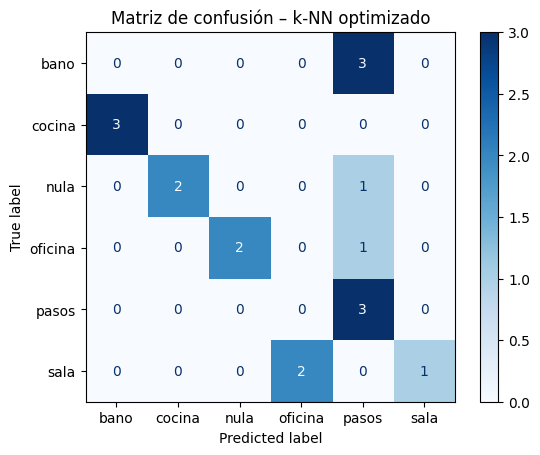

k-NN optimizado | F1-score macro: 0.1742


In [ ]:
knn_opt = grid_knn.best_estimator_

resultados["k-NN (opt)"] = evaluar_modelo(
    knn_opt,
    X_train,
    X_test,
    y_train,
    y_test,
    "k-NN optimizado"
)



In [ ]:
knn = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier(n_neighbors=1))
])


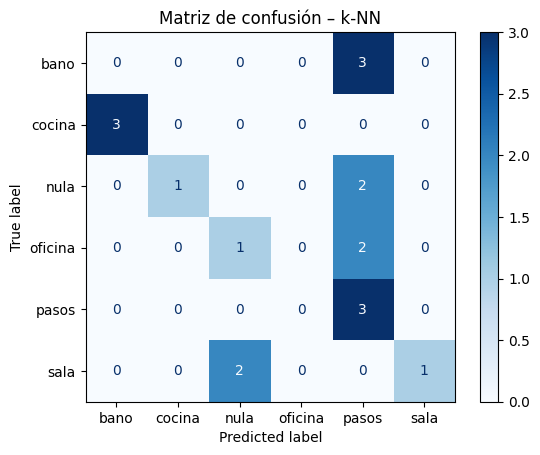

k-NN | F1-score macro: 0.1603


In [ ]:

resultados["k-NN"] = evaluar_modelo(
    knn, X_train, X_test, y_train, y_test, "k-NN"
)

# XGBOOST

In [ ]:
from xgboost import XGBClassifier

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)


In [ ]:
param_grid_xgb = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}


In [ ]:
xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=6,          # ← tus clases
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
)

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_xgb.fit(X_train, y_train_enc)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


In [ ]:
print("Mejores parámetros XGBoost:", grid_xgb.best_params_)


In [ ]:
xgb_opt = grid_xgb.best_estimator_

y_pred_enc = xgb_opt.predict(X_test)
y_pred = le.inverse_transform(y_pred_enc)


In [ ]:
resultados["XGBoost (opt)"] = evaluar_modelo(
    xgb_opt,
    X_train,
    X_test,
    y_train_enc,
    y_test_enc,
    "XGBoost optimizado"
)


In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softmax",
    eval_metric="mlogloss",
    random_state=42
)


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_train_xgb = le.fit_transform(y_train)
y_test_xgb  = le.transform(y_test)


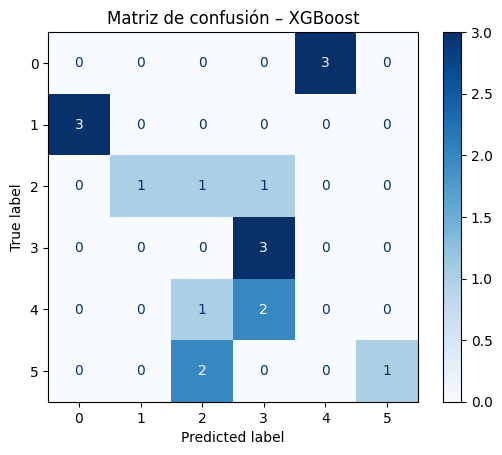

XGBoost | F1-score macro: 0.2421


In [ ]:
resultados["XGBoost"] = evaluar_modelo(
    xgb, X_train, X_test, y_train_xgb, y_test_xgb, "XGBoost"
)


## F1

In [ ]:

pd.DataFrame.from_dict(
    resultados, orient="index", columns=["F1_macro"]
)


,F1_macro
Random Forest,0.186508
SVM,0.113636
k-NN,0.263228
XGBoost,0.242063


## YAMNet

In [16]:
import os
import librosa
import soundfile as sf
import pandas as pd
import numpy as np

input_path = path_1  # tu carpeta de audios
output_path = path_1

registros = []

def duracion_audio(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    return len(audio)/sr

def estandarizar_nombre(file):
    parts = file.replace(".wav","").split("_")
    if len(parts) >= 2:
        return "_".join(parts[:3]) + ".wav"
    return None

def recortar_a_10s(audio, sr):
    max_samples = int(10*sr)
    if len(audio) > max_samples:
        return audio[:max_samples], True
    elif len(audio) < max_samples:
        return np.pad(audio, (0, max_samples-len(audio))), True
    return audio, False

def reducir_ruido(audio, sr):
    return audio  # placeholder, sin reducción por ahora

def normalizar_audio(audio):
    if np.max(np.abs(audio)) == 0:
        return audio
    return audio / np.max(np.abs(audio))

# Recorremos todos los audios
for root, _, files in os.walk(input_path):
    for file in files:
        if not file.lower().endswith(".wav"):
            continue

        input_file = os.path.join(root, file)
        dur = duracion_audio(input_file)
        nuevo_nombre = estandarizar_nombre(file)
        nombre_ok = nuevo_nombre is not None

        estado = []
        if abs(dur - 10.0) > 0.05:
            estado.append("RECORTADO")
        if not nombre_ok:
            estado.append("NOMBRE")
        estado = "OK" if not estado else ",".join(estado)

        if nombre_ok:
            audio, sr = librosa.load(input_file, sr=None)
            audio, _ = recortar_a_10s(audio, sr)
            audio = reducir_ruido(audio, sr)
            audio = normalizar_audio(audio)

            output_file = os.path.join(output_path, nuevo_nombre)
            sf.write(output_file, audio, sr)

        registros.append({
            "archivo_original": file,
            "archivo_final": nuevo_nombre,
            "duracion_original": round(dur, 3),
            "estado": estado
        })

# Crear DataFrame y guardar CSV
df_registros = pd.DataFrame(registros)
csv_path = os.path.join(output_path, "audios_registros.csv")
df_registros.to_csv(csv_path, index=False)
print(f"CSV guardado en: {csv_path}")
print(df_registros.head())


CSV guardado en: /content/drive/MyDrive/P1/audios_registros.csv
      archivo_original        archivo_final  duracion_original estado
0  DISC_oficina_02.wav  DISC_oficina_02.wav               10.0     OK
1     DISC_sala_01.wav     DISC_sala_01.wav               10.0     OK
2  DISC_oficina_01.wav  DISC_oficina_01.wav               10.0     OK
3    DISC_pasos_02.wav    DISC_pasos_02.wav               10.0     OK
4     DISC_sala_03.wav     DISC_sala_03.wav               10.0     OK


In [17]:
df_features = pd.read_csv(csv_path)
df_features = df_features[df_features["estado"]=="OK"]

# Separar test y train
df_test = df_features[df_features["archivo_final"].str.contains("JMRR")]
df_train = df_features[~df_features["archivo_final"].str.contains("JMRR")]

print(f"Train: {len(df_train)}, Test: {len(df_test)}")


Train: 179, Test: 18


In [18]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import csv
from scipy.io import wavfile
from scipy import signal

# Load pre-trained YAMNet
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

def class_names_from_csv(class_map_csv_text):
    class_names = []
    with tf.io.gfile.GFile(class_map_csv_text) as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            class_names.append(row['display_name'])
    return class_names

class_map_path = yamnet_model.class_map_path().numpy()
class_names = class_names_from_csv(class_map_path)


In [19]:
def ensure_sample_rate(original_sample_rate, waveform, desired_sample_rate=16000):
    """Resample waveform if needed"""
    if original_sample_rate != desired_sample_rate:
        desired_length = int(round(float(len(waveform)) / original_sample_rate * desired_sample_rate))
        waveform = signal.resample(waveform, desired_length)
    return desired_sample_rate, waveform

def load_audio_yamnet(file_path):
    sr, audio = wavfile.read(file_path)
    sr, audio = ensure_sample_rate(sr, audio)
    waveform = audio / np.max(np.abs(audio))  # normalize [-1,1]
    return waveform


In [20]:
def extract_embeddings(df):
    embeddings = []
    labels = []

    for idx, row in df.iterrows():
        file_path = os.path.join(output_path, row['archivo_final'])
        waveform = load_audio_yamnet(file_path)
        scores, embedding, spectrogram = yamnet_model(waveform)
        mean_embedding = tf.reduce_mean(embedding, axis=0).numpy()  # promedio temporal
        embeddings.append(mean_embedding)
        labels.append(row['archivo_final'].split("_")[1])  # suponiendo la clase está en el nombre

    return np.array(embeddings), np.array(labels)

X_train, y_train = extract_embeddings(df_train)
X_test, y_test = extract_embeddings(df_test)

print(f"Embeddings shape: {X_train.shape}, Labels shape: {y_train.shape}")


Embeddings shape: (179, 1024), Labels shape: (179,)


F1 macro: 0.4583333333333333


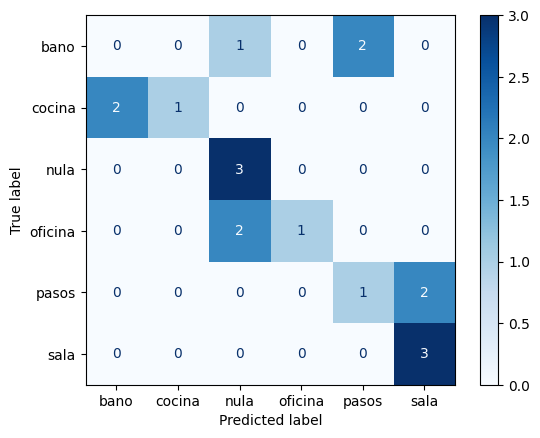

In [22]:
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

svm = SVC(kernel='linear', class_weight='balanced')
svm.fit(X_train, y_train_enc)

y_pred = svm.predict(X_test)
print("F1 macro:", f1_score(y_test_enc, y_pred, average='macro'))

cm = confusion_matrix(y_test_enc, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues")
